---

# JuliaDB - Testing

---


In [87]:
using JuliaDB, IndexedTables, OnlineStats

In [88]:
using StatsPlots, StaticArrays   # Note the name change from Stat[s]Plots

## Flight statistics example

In [6]:
cd("/Users/malcolm/PacktPub/Chp09")

# Load the data
flights = loadtable("Files/hhflights.csv");

In [7]:
# Define a filter (1st day os each month)

filter(i -> (i.Month == 1) && (i.DayofMonth == 1), flights)

Table with 547 rows, 21 columns:
Columns:
#   colname            type
──────────────────────────────
1   Year               Int64
2   Month              Int64
3   DayofMonth         Int64
4   DayOfWeek          Int64
5   DepTime            Int64
6   ArrTime            Int64
7   UniqueCarrier      String
8   FlightNum          Int64
9   TailNum            String
10  ActualElapsedTime  Int64
11  AirTime            Int64
12  ArrDelay           Int64
13  DepDelay           Int64
14  Origin             String
15  Dest               String
16  Distance           Int64
17  TaxiIn             Int64
18  TaxiOut            Int64
19  Cancelled          Int64
20  CancellationCode   Missing
21  Diverted           Int64

In [8]:
# Select all flights Departure/Arrival/FlightNum
select(flights, (:DepTime, :ArrTime, :FlightNum))

Table with 223874 rows, 3 columns:
DepTime  ArrTime  FlightNum
───────────────────────────
1400     1500     428
1401     1501     428
1352     1502     428
1403     1513     428
1405     1507     428
1359     1503     428
1359     1509     428
1355     1454     428
1443     1554     428
1443     1553     428
1429     1539     428
1419     1515     428
⋮
1939     2119     124
556      745      280
1026     1208     782
1611     1746     1050
758      1051     201
1307     1600     471
1818     2111     1191
2047     2334     1674
912      1031     127
656      812      621
1600     1713     1597

In [9]:
filter(i -> i.DepDelay > 60, select(flights, (:UniqueCarrier, :DepDelay)))

Table with 10164 rows, 2 columns:
UniqueCarrier  DepDelay
───────────────────────
"AA"           90
"AA"           67
"AA"           74
"AA"           125
"AA"           82
"AA"           99
"AA"           70
"AA"           61
"AA"           74
"AS"           73
"B6"           136
"B6"           68
⋮
"WN"           129
"WN"           61
"WN"           70
"WN"           76
"WN"           63
"WN"           144
"WN"           117
"WN"           124
"WN"           72
"WN"           70
"WN"           78

In [157]:
# Apply function to each row, using 'map'

speedy = round.(map(i -> i.Distance / i.AirTime * 60, flights), digits=4)

223874-element Array{Float64,1}:
 336.0   
 298.6667
 280.0   
 344.6154
 305.4545
 298.6667
 312.5581
 336.0   
 327.8049
 298.6667
 320.0   
 327.8049
 305.4545
   ⋮     
 261.8182
 508.8889
 473.7931
 479.3023
 496.6265
 468.6   
 478.1633
 483.0928
 498.5106
 445.5738
 424.6875
 460.678 

In [14]:
# Add speed to the dataset
flights = pushcol(flights, :Speedy, speedy)

Table with 223874 rows, 23 columns:
Columns:
#   colname            type
──────────────────────────────
1   Year               Int64
2   Month              Int64
3   DayofMonth         Int64
4   DayOfWeek          Int64
5   DepTime            Int64
6   ArrTime            Int64
7   UniqueCarrier      String
8   FlightNum          Int64
9   TailNum            String
10  ActualElapsedTime  Int64
11  AirTime            Int64
12  ArrDelay           Int64
13  DepDelay           Int64
14  Origin             String
15  Dest               String
16  Distance           Int64
17  TaxiIn             Int64
18  TaxiOut            Int64
19  Cancelled          Int64
20  CancellationCode   Missing
21  Diverted           Int64
22  Speed              Float64
23  Speedy             Float64

In [15]:
using ShiftedArrays
y = groupby(length, flights, :Month)
lengths = columns(y, :length)
pushcol(y, :change, lengths .- lag(lengths))

Table with 12 rows, 3 columns:
Month  length  change
──────────────────────
1      18665   missing
2      15975   -2690
3      19267   3292
4      18266   -1001
5      18830   564
6      19360   530
7      20312   952
8      19927   -385
9      17914   -2013
10     18548   634
11     17933   -615
12     18877   944

In [16]:
# Apply several operations
import Lazy
Lazy.@as x flights begin
    select(x, (:UniqueCarrier, :DepDelay))
    filter(i -> i.DepDelay > 60, x)
end

Table with 10164 rows, 2 columns:
UniqueCarrier  DepDelay
───────────────────────
"AA"           90
"AA"           67
"AA"           74
"AA"           125
"AA"           82
"AA"           99
"AA"           70
"AA"           61
"AA"           74
"AS"           73
"B6"           136
"B6"           68
⋮
"WN"           129
"WN"           61
"WN"           70
"WN"           76
"WN"           63
"WN"           144
"WN"           117
"WN"           124
"WN"           72
"WN"           70
"WN"           78

In [17]:
# Performance

using BenchmarkTools
sortedflights = reindex(flights, :Dest)

Table with 223874 rows, 23 columns:
Columns:
#   colname            type
──────────────────────────────
1   Dest               String
2   Year               Int64
3   Month              Int64
4   DayofMonth         Int64
5   DayOfWeek          Int64
6   DepTime            Int64
7   ArrTime            Int64
8   UniqueCarrier      String
9   FlightNum          Int64
10  TailNum            String
11  ActualElapsedTime  Int64
12  AirTime            Int64
13  ArrDelay           Int64
14  DepDelay           Int64
15  Origin             String
16  Distance           Int64
17  TaxiIn             Int64
18  TaxiOut            Int64
19  Cancelled          Int64
20  CancellationCode   Missing
21  Diverted           Int64
22  Speed              Float64
23  Speedy             Float64

In [25]:
# println("Presorted timing:")
# @benchmark groupby(NamedTuple(avg_delay = mean.(dropmissing(sortedflights), sortedflights, select = :ArrDelay)))

In [26]:
# Grouping

using StatsBase, Nullables
fc = filter(t->!isnull(t.DepDelay), flights)

Table with 223874 rows, 23 columns:
Columns:
#   colname            type
──────────────────────────────
1   Year               Int64
2   Month              Int64
3   DayofMonth         Int64
4   DayOfWeek          Int64
5   DepTime            Int64
6   ArrTime            Int64
7   UniqueCarrier      String
8   FlightNum          Int64
9   TailNum            String
10  ActualElapsedTime  Int64
11  AirTime            Int64
12  ArrDelay           Int64
13  DepDelay           Int64
14  Origin             String
15  Dest               String
16  Distance           Int64
17  TaxiIn             Int64
18  TaxiOut            Int64
19  Cancelled          Int64
20  CancellationCode   Missing
21  Diverted           Int64
22  Speed              Float64
23  Speedy             Float64

In [27]:
gfc = groupby(fc, :UniqueCarrier, select = (:Month, :DayofMonth, :DepDelay), flatten = true) do dd
    rks = ordinalrank(column(dd, :DepDelay), rev = true)
    sort(dd[rks .<= 2], by =  i -> i.DepDelay, rev = true)
end

Table with 30 rows, 4 columns:
UniqueCarrier  Month  DayofMonth  DepDelay
──────────────────────────────────────────
"AA"           12     12          970
"AA"           11     19          677
"AS"           2      28          172
"AS"           7      6           138
"B6"           10     29          310
"B6"           8      19          283
"CO"           8      1           981
"CO"           1      20          780
"DL"           10     25          730
"DL"           4      5           497
"EV"           6      25          479
"EV"           1      5           465
⋮
"OO"           4      4           343
"UA"           6      21          869
"UA"           9      18          588
"US"           4      19          425
"US"           8      26          277
"WN"           9      29          503
"WN"           5      12          499
"XE"           12     29          628
"XE"           12     29          511
"YV"           4      22          54
"YV"           4      30          46

In [29]:
#=
groupby(fc, :UniqueCarrier, select = (:Month, :DayofMonth, :DepDelay), flatten = true) do dd
    select(dd, 1:2, by = i -> i.DepDelay, rev = true)
end
=#

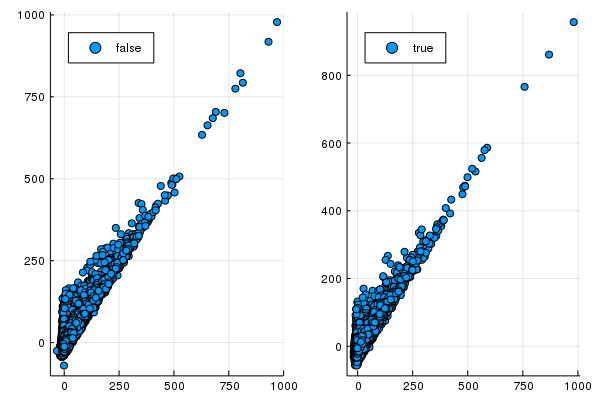

In [30]:
# Visualization

using StatsPlots
gr(fmt = :png) # choose the fast GR backend and set format to png: svg would probably crash with so many points
@df flights scatter(:DepDelay, :ArrDelay, group = :Distance .> 1000,  fmt = :png, layout = 2, legend = :topleft)


---

## Financial Example

In [31]:
# using Pkg

# path = Pkg.dir("JuliaDB", "test", "sample")
# path = joinpath(dirname(pathof(JuliaDB)), "..","test","sample")
path =  joinpath(homedir(), "PacktPub","Chp09","Files","Stocks")

"/Users/malcolm/PacktPub/Chp09/Files/Stocks"

In [34]:
### sampledata = loadfiles(path, indexcols=["date", "ticker"])
stockdata = loadndsparse(path, indexcols=["date", "ticker"])

2-d NDSparse with 288 values (5 field named tuples):
date        ticker  │ open     high     low      close   volume
────────────────────┼─────────────────────────────────────────────
2010-01-01  "GOOGL" │ 626.95   629.51   540.99   626.75  1.78022e8
2010-01-01  "GS"    │ 170.05   178.75   154.88   173.08  2.81862e8
2010-01-01  "KO"    │ 57.16    57.4301  54.94    57.04   1.92693e8
2010-01-01  "XRX"   │ 8.54     9.48     8.91     8.63    3.00838e8
2010-02-01  "GOOGL" │ 534.602  547.5    531.75   533.02  1.03964e8
2010-02-01  "GS"    │ 149.82   160.21   156.99   153.13  2.3197e8
2010-02-01  "KO"    │ 54.51    55.92    53.09    54.38   2.28993e8
2010-02-01  "XRX"   │ 8.75     9.4      9.31     8.97    3.10746e8
2010-03-01  "GOOGL" │ 529.2    588.275  569.74   532.69  1.67381e8
2010-03-01  "GS"    │ 156.51   178.73   171.66   156.54  2.40365e8
2010-03-01  "KO"    │ 53.22    55.36    55.29    53.27   2.67852e8
2010-03-01  "XRX"   │ 9.38     10.17    9.78     9.55    2.84334e8
             

In [36]:
using Dates
stockdata[Date("2010-06-01"), "GOOGL"] 

(open = 480.43, high = 509.25, low = 457.83, close = 482.37, volume = 1.196056e8)

In [37]:
stockdata[Date("2012-01"):Dates.Month(1):Date("2014-12"), ["GOOGL", "KO"]]

2-d NDSparse with 72 values (5 field named tuples):
date        ticker  │ open     high     low      close   volume
────────────────────┼─────────────────────────────────────────────
2012-01-01  "GOOGL" │ 652.94   670.25   584.0    665.41  1.47137e8
2012-01-01  "KO"    │ 70.15    70.71    67.98    70.14   1.50116e8
2012-02-01  "GOOGL" │ 584.94   625.6    619.77   580.83  9.46335e7
2012-02-01  "KO"    │ 67.88    69.98    69.5     67.85   1.43833e8
2012-03-01  "GOOGL" │ 622.26   658.589  653.49   622.4   9.45647e7
2012-03-01  "KO"    │ 69.87    74.39    74.14    69.6    2.05125e8
2012-04-01  "GOOGL" │ 640.77   653.14   616.082  646.92  1.17637e8
2012-04-01  "KO"    │ 73.83    77.82    76.9     74.14   1.46185e8
2012-05-01  "GOOGL" │ 603.79   637.85   590.0    604.43  1.17228e8
2012-05-01  "KO"    │ 76.54    77.74    75.22    76.93   1.67695e8
2012-06-01  "GOOGL" │ 571.79   587.89   580.13   570.98  9.29145e7
2012-06-01  "KO"    │ 73.99    78.19    76.67    73.09   1.39787e8
             

In [133]:
filter(x ->  x.close >= 100.0 && x.close <= 140.0, stockdata[:, "GS"])

1-d NDSparse with 17 values (5 field named tuples):
date       │ open    high     low     close   volume
───────────┼───────────────────────────────────────────
2010-07-01 │ 131.69  153.41   153.15  131.14  2.2909e8
2010-09-01 │ 139.01  154.7    146.98  139.74  1.402e8
2011-06-01 │ 139.95  140.0    133.8   136.17  1.35784e8
2011-07-01 │ 133.43  139.25   136.6   136.65  1.13317e8
2011-08-01 │ 136.92  137.34   117.8   134.15  2.3048e8
2011-09-01 │ 115.55  115.55   98.4    112.16  1.66764e8
2011-11-01 │ 103.49  109.257  96.01   103.54  1.50194e8
2012-02-01 │ 112.61  118.66   118.13  113.45  1.1445e8
2012-03-01 │ 115.97  128.72   125.47  121.13  1.48683e8
2012-04-01 │ 124.14  125.54   115.3   124.9   1.18237e8
2012-05-01 │ 114.84  116.48   96.65   115.33  1.21117e8
2012-08-01 │ 101.27  107.34   106.58  100.09  7.08954e7
2012-09-01 │ 105.55  122.6    115.01  106.41  9.11556e7
2012-10-01 │ 116.67  126.48   122.6   116.86  9.61152e7
2012-11-01 │ 122.82  126.73   119.44  124.85  7.84732e7
2012

In [158]:
### select(stockdata, 1=>Dates.ismonday, 2=>x->startswith(x, "G"))
goFri = filter((1=>Dates.isfriday, 2=>x->startswith(x, "X")), stockdata)

2-d NDSparse with 10 values (5 field named tuples):
date        ticker │ open   high    low    close  volume
───────────────────┼───────────────────────────────────────
2010-01-01  "XRX"  │ 8.54   9.48    8.91   8.63   3.00838e8
2010-10-01  "XRX"  │ 10.41  11.73   11.7   10.5   2.73763e8
2011-04-01  "XRX"  │ 10.71  11.03   10.18  10.88  2.79543e8
2011-07-01  "XRX"  │ 10.38  10.83   9.55   10.71  2.71723e8
2012-06-01  "XRX"  │ 7.06   7.88    7.88   7.12   2.4474e8
2013-02-01  "XRX"  │ 8.1    8.23    8.2    8.02   1.71174e8
2013-03-01  "XRX"  │ 8.07   8.77    8.62   8.15   1.63994e8
2013-11-01  "XRX"  │ 10.01  11.48   11.41  10.02  2.2431e8
2014-08-01  "XRX"  │ 13.18  13.88   13.77  13.04  1.40391e8
2015-05-01  "XRX"  │ 11.55  11.859  11.5   11.52  2.09801e8

In [146]:
# Select just the GOOGLE stocks 
googl = stockdata[:, ["GOOGL"]]

# Create a set of spread values (i.e High - Low)
spread = map(x -> x.high - x.low, googl)

# Compute the average spread
round(reduce(+,(mean.(spread)))/length(spread), digits=4)

32.7057

In [145]:
# More realistic is the average gain (i.e. Open - Close)
gain = map(x -> x.open - x.close, googl)
round(reduce(+,(mean.(gain)))/length(gain), digits=4)

# Note that dataset is only the FIRST day in the month so the value is not necessarily 

-0.3395

In [134]:
# pushcol(googl, :gain, gain)

In [144]:
# sratio = (Open - Close)/(High - Low ) ϵ [-1.0,1.0] 
ρ = map(x -> (x.open - x.close) / (x.high - x.low), googl)
round(reduce(+,(mean.(ρ)))/length(ρ),digits=4)

# If this is Weiner (Brownian) process the value should be about 0.5

0.2758

In [100]:
using OnlineStats

In [116]:
reduce(Mean(), googl; select = :close)

Mean: n=72 | value=663.283

In [120]:
groupreduce(Mean(),stockdata,:ticker; select=:close)

1-d NDSparse with 4 values (Mean{Float64,EqualWeight}):
ticker  │
────────┼───────────────────────────
"GOOGL" │ Mean: n=72 | value=663.283
"GS"    │ Mean: n=72 | value=152.9
"KO"    │ Mean: n=72 | value=51.0185
"XRX"   │ Mean: n=72 | value=9.99694

In [89]:
using StatsPlots

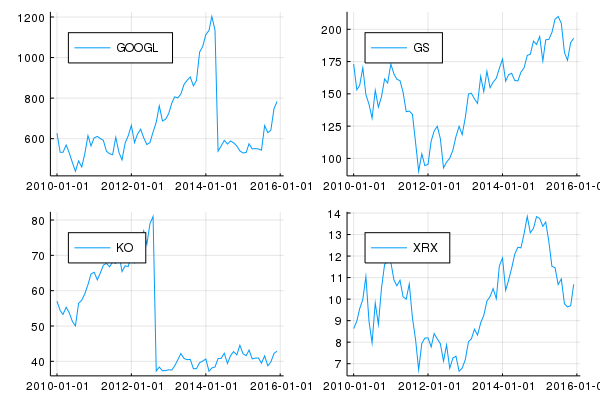

In [126]:
@df stockdata plot(:date, :close, group=:ticker, layout = 4, legend = :topleft)